In [2]:
from openai import OpenAI
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
client = OpenAI()

In [114]:
# Create a vector store caled "Company Policies"
vector_store = client.beta.vector_stores.create(name="Stock Data")
 
# Ready the files for upload to OpenAI 
# At the time of writing this, .csv and .xlsx files are not supported, but .pdf and .json are.
file_paths = ["stock-data/MSFT_weekly_stock_data.pdf"]
file_streams = [open(path, "rb") for path in file_paths]
 
# Use the upload and poll SDK helper to upload the files, add them to the vector store,
# and poll the status of the file batch for completion.
file_batch = client.beta.vector_stores.file_batches.upload_and_poll(
  vector_store_id=vector_store.id, files=file_streams
)
 
# You can print the status and the file counts of the batch to see the result of this operation.
print(file_batch.status)
print(file_batch.file_counts)

BadRequestError: Error code: 400 - {'error': {'message': 'Files with extensions [.csv] are not supported for retrieval. See https://platform.openai.com/docs/assistants/tools/file-search/supported-files', 'type': 'invalid_request_error', 'param': 'file_ids', 'code': 'unsupported_file'}}

In [55]:
# Create the assistant
assistant = client.beta.assistants.create(
    name="Stock Price Visualizer",
    instructions="Use code interpreter and the provided files to visualize stock data",
    tools = [{'type':'file_search'}, {'type':'code_interpreter'}],
    tool_resources={"file_search": {"vector_store_ids": [vector_store.id]}},
    model = 'gpt-4o',
)

In [56]:
assistant.id

'asst_vKZTIQbs3hoAhPCz1Ao6LVY3'

In [90]:
# Create a thread
thread = client.beta.threads.create()

In [91]:
thread.id

'thread_mxWzvVmGNjIwkn1JIadrw4Nh'

In [89]:
client.beta.threads.delete('thread_FqixxOrMjsHB62sjad4Syal4')

ThreadDeleted(id='thread_FqixxOrMjsHB62sjad4Syal4', deleted=True, object='thread.deleted')

In [92]:
# Create our first message.
message_1 = client.beta.threads.messages.create(
    thread_id = thread.id,
    role = 'user',
    content = 'Visualize the Microsoft Corporations stock prices in the last 2 years'
)

In [93]:
# Create a run for the thread. Please note that runs with file_search take longer than normal!
run = client.beta.threads.runs.create(
    assistant_id = assistant.id,
    thread_id = thread.id)

In [102]:
run.status

'queued'

In [103]:
messages = client.beta.threads.messages.list(
    thread_id = thread.id
)

In [104]:
for message in messages:
    print(message)
    print('\n')

Message(id='msg_gQmhXQxtvutv2bCiPER26Yvx', assistant_id='asst_vKZTIQbs3hoAhPCz1Ao6LVY3', attachments=[], completed_at=None, content=[ImageFileContentBlock(image_file=ImageFile(file_id='file-iS5EXngVXUoeJVG3V70Kj5dn', detail=None), type='image_file'), TextContentBlock(text=Text(annotations=[], value="The visualization above represents Microsoft Corporation's (MSFT) weekly stock prices over the past two years. Each point on the graph corresponds to the closing price of MSFT at the end of a trading week. The trend demonstrates a relatively consistent increase in the stock price over the observed period."), type='text')], created_at=1718457185, incomplete_at=None, incomplete_details=None, metadata={}, object='thread.message', role='assistant', run_id='run_HTTMdZ4Y1w8YDYLbQha1CDt9', status=None, thread_id='thread_mxWzvVmGNjIwkn1JIadrw4Nh')


Message(id='msg_XZXXwJ4pL1SGVtKRyxZlWUG0', assistant_id=None, attachments=[], completed_at=None, content=[TextContentBlock(text=Text(annotations=[], va

In [105]:
messages.data[0].content[1].text.value


"The visualization above represents Microsoft Corporation's (MSFT) weekly stock prices over the past two years. Each point on the graph corresponds to the closing price of MSFT at the end of a trading week. The trend demonstrates a relatively consistent increase in the stock price over the observed period."

In [106]:
image_response = messages.data[0].content[0].image_file.file_id

In [107]:
image_response

'file-iS5EXngVXUoeJVG3V70Kj5dn'

In [108]:
image_file_binary = client.files.content(image_response)

In [109]:
image_file_binary

In [110]:
with open('image_file.png', 'wb') as file:
    file.write(image_file_binary.content)

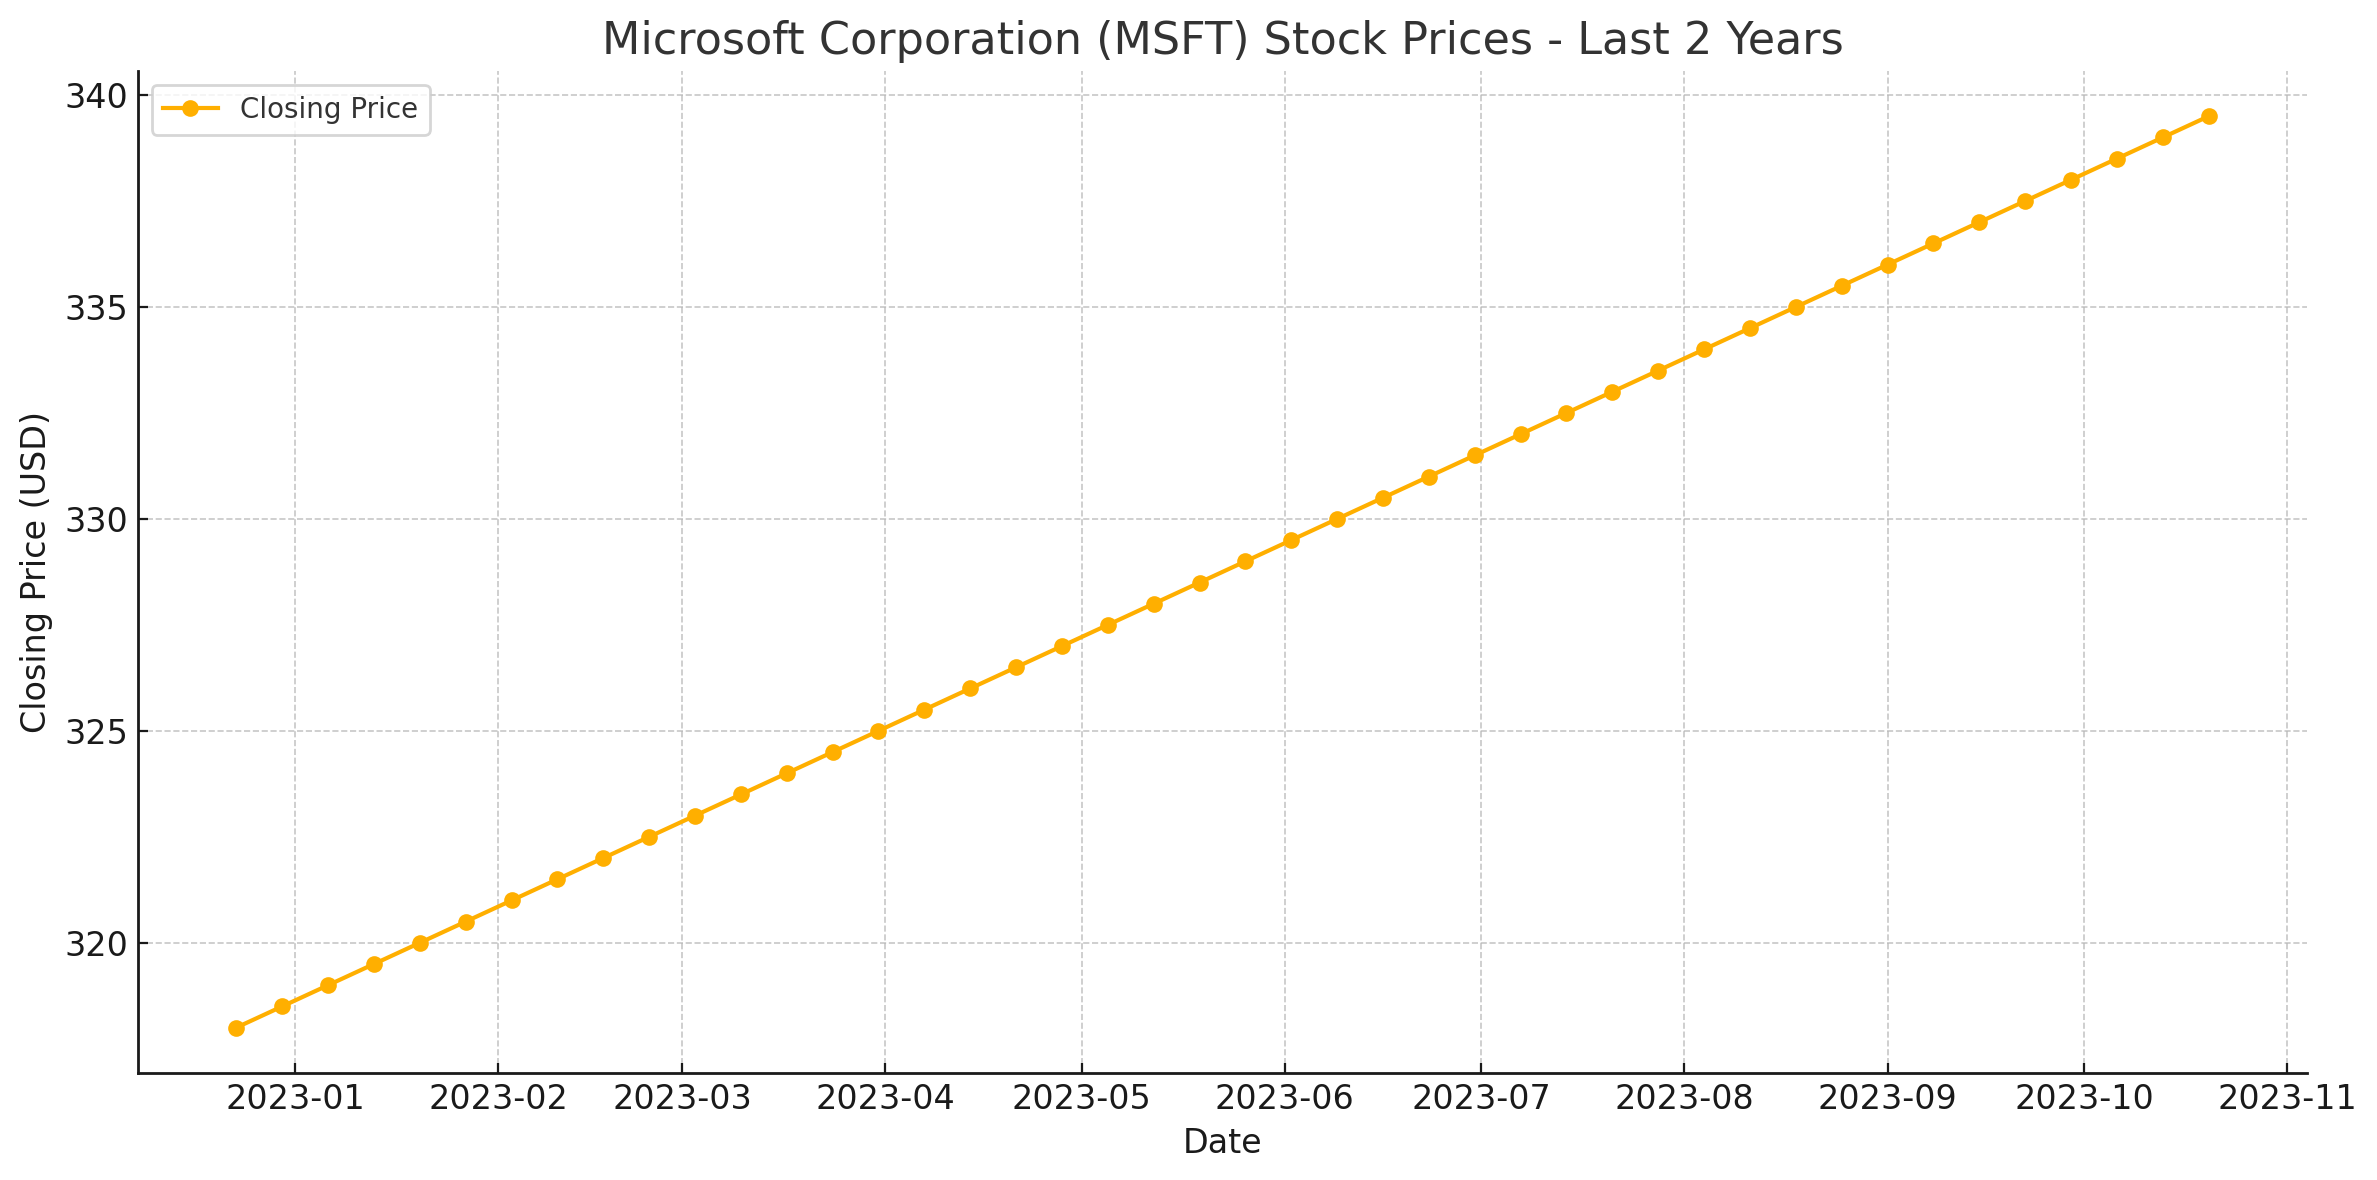

In [111]:
from IPython.display import Image
Image(filename='image_file.png')

In [34]:
run_steps = client.beta.threads.runs.steps.list(
    thread_id = thread.id,
    run_id = run.id
)

In [35]:
for step in run_steps:
    print(step.step_details)
    print('\n')

ToolCallsStepDetails(tool_calls=[FileSearchToolCall(id='call_K5Vp7TtF9u6dMjAEe8Zi65gY', file_search={}, type='file_search')], type='tool_calls')




In [36]:
files = client.beta.vector_stores.files.list(
    vector_store_id=vector_store.id
)

In [37]:
files.data

[VectorStoreFile(id='file-G3qJRvbFD22PdSPXUuRZgmMh', created_at=1718447401, last_error=None, object='vector_store.file', status='completed', usage_bytes=20833, vector_store_id='vs_nZdP2dvTcuARXjBb34k6G5Mn', chunking_strategy=ChunkingStrategyStatic(static=ChunkingStrategyStaticStatic(chunk_overlap_tokens=400, max_chunk_size_tokens=800), type='static'))]

In [53]:
# Delete the assistant:
response = client.beta.assistants.delete(assistant.id)

In [54]:
response

AssistantDeleted(id='asst_7Cefhv1RcLP26osVDB3zbmhp', deleted=True, object='assistant.deleted')